# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения, c различными гиперпараметрами (коэффициент обучения и betas)
    * SGD, SGD+momentum, Adam
    
За все три задания 1 бал, срок выполнения 2 недели, после 0.5 бала.

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку pytorch. Получаем на вход тензор размером $(B, C_{in}, H, W)$, на выходе получаем тензор $(B, C_{out}, H_{out}, W_{out})$.
$$
B \ - \ размерность\ батча. \\
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки:
$$
\begin{equation*}
\text{out}(B_i, C_{out_j}) = \text{bias}(C_{out_j}) +
                        \sum_{k = 0}^{C_{in} - 1} \text{kernel}(C_{out_j}, k) \star \text{x}(B_i, k)
\end{equation*},
$$

где $\large k $ - ядро свертки, с парамерами $C_{in}, H_k, W_k, stride_{H,W}, padding_{H,W}  $.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [1]:
def get_x_with_padding(x, padding):
    size = x.size() 
    if padding[0] != 0:
        add_h = torch.zeros(size[0], size[1], padding[0], size[3])
        x = torch.cat([add_h, x, add_h], dim=2)
        size = x.size()
    if padding[1] != 0:
        add_w = torch.zeros(size[0], size[1], size[2], padding[1])
        x = torch.cat([add_w, x, add_w], dim=3)
    return x

In [2]:
def get_value_of_cell(kernel, x, b, h, w, stride):
    k_size = kernel.size()
    part_of_x = x.narrow(0, b, 1)
    part_of_x = part_of_x.narrow(2, h * stride[0], k_size[1])
    part_of_x = part_of_x.narrow(3, w * stride[1], k_size[2])
    return torch.sum(kernel * part_of_x)

In [3]:
def get_result(x, kernel, res_size, stride):
    result = torch.zeros(res_size)
    for b in range(res_size[0]):
        for h in range(res_size[2]):
            for w in range(res_size[3]):
                result[b, 0, h, w] = get_value_of_cell(kernel, x, (b, h, w), stride)
    return result

In [4]:
def get_res_size(size, k_size, stride):
    res_size = []
    res_size.append(size[0])
    res_size.append(1)
    res_size.append((size[2] - k_size[1]) / stride[0] + 1)
    res_size.append((size[3] - k_size[2]) / stride[1] + 1)
    return res_size

In [5]:
# прототип функции 
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):        
    size = x.size()
    k_size = kernel.size()
    if len(size) == 3:
        x = x.unsqueeze(0)
    x = get_x_with_padding(x, padding)
    size = x.size()
    res_size = get_res_size(size, k_size, stride)
    result = get_result(x, kernel, res_size, stride)
    if bias is not None:
        result += bias
    res_size = result.size()
    if res_size[0] == 1:
        result = result.squeeze(0)
    if res_size[1] == 1:
        result = result.squeeze(0)
    print(result.size())
    return result

## Тестируем функцию свертки

### Загружаем картинку 

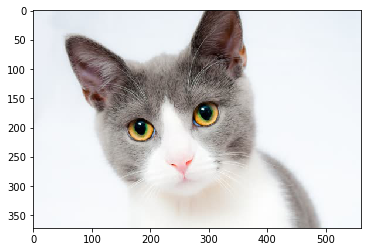

In [8]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [9]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [10]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])
torch.Size([370, 558])


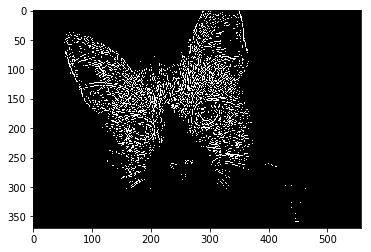

In [423]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [424]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
torch.Size([370, 558])


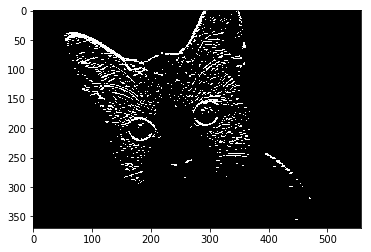

In [425]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [426]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])
torch.Size([370, 558])


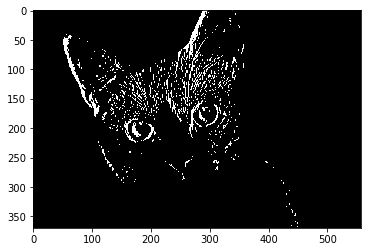

In [427]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


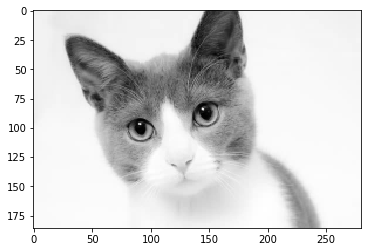

In [428]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

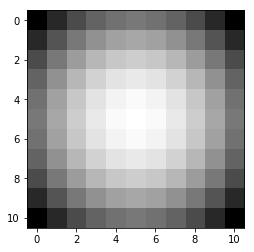

In [429]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])
torch.Size([362, 550])


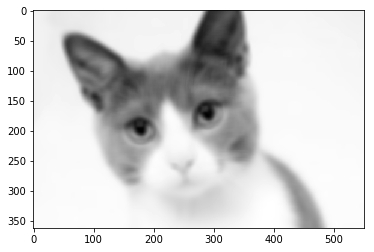

In [430]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

# 2. Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \gamma, b $ - параметры расчитанные в процессе тренировки слоя.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй

Нужные функции
```python
import torch
torch.zeros #- создать тензор заполненный нулями
torch.ones #- создать тензор заполненный единицами
torch.Tensor #- создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  #- среднее и дисперсия
x.uniform_ #- заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) #- разширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1 
```

In [14]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.1, epsilon=1e-8, training=True):
        """
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super(BatchNorm2d, self).__init__()
        
        self.beta = beta
        self.epsilon = epsilon
        self.afine = afine
        self.in_channels = in_channels
        self.training = training
        self.v = torch.zeros(in_channels)
        self.s = torch.ones(in_channels)
        self.runing_mean = torch.zeros(in_channels)
        self.runing_var = torch.zeros(in_channels)

        
        self.gamma = torch.FloatTensor(in_channels).uniform_()
        self.b = torch.zeros(in_channels)
    
    def train(self, trainig):
        self.trainig = trainig
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        """
        size = x.size()        
        while len(size) < 4:
            x = x.unsqueeze(0)
            size = x.size()
        mean = torch.FloatTensor([x[:, i, :, :].mean() for i in range(self.in_channels)])
        var = torch.FloatTensor([x[:, i, :, :].var() for i in range(self.in_channels)])
        if self.training:                
            self.v = self.beta * self.v + (1. - self.beta) * mean
            self.s = self.beta * self.s + (1. - self.beta) * var 
        self.runing_mean = self.v.mean()
        self.runing_var = self.s.mean()
        result = torch.zeros(size)
        ones = torch.ones(x.size())
        shape = (size[0], size[2], size[3])
        for j in range(self.in_channels):
            result[:, j, :, :] = (x[:, j, :, :] - torch.ones(shape) * self.v[j])\
            / (self.s[j] + self.epsilon) ** (1. / 2.)
        if self.afine:
            for j in range(self.in_channels):
                result[:, j, :, :] = result[:, j, :, :] * self.gamma[j] + torch.ones(shape) * self.b[j]
        result[result < 0.] = 0.
        return result

### Проверяем работу батч нормализации на котэ

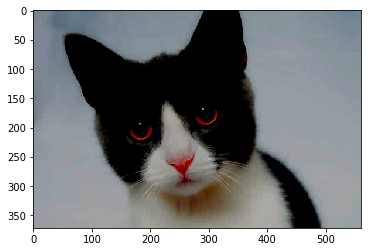

In [15]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

torch.Size([3, 372, 560])


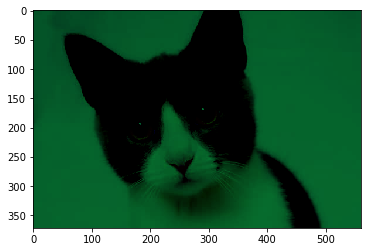

In [16]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [17]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [18]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


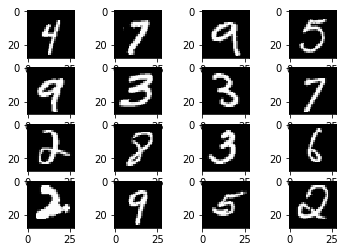

In [19]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [20]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
#             print('x shape')
#             print(x.size())
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [459]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
'''
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
'''
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

mean_curve_09 type
<type 'list'>
mean_curve_09 size
2187


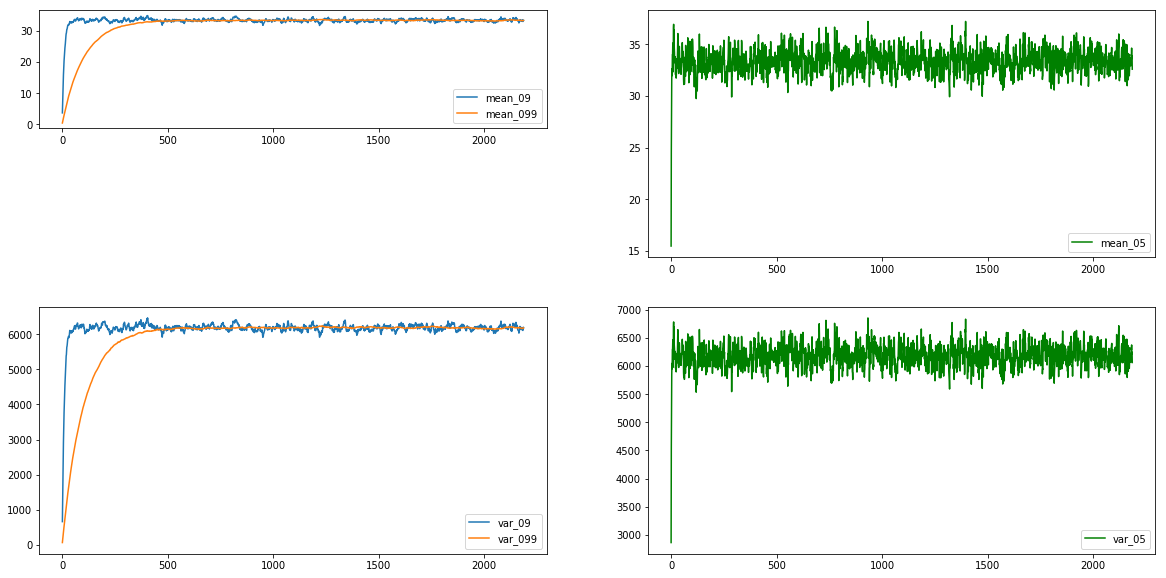

In [460]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
print('mean_curve_09 type')
print(type(mean_curve_09))
print('mean_curve_09 size')
print(len(mean_curve_09))
# print('mean_curve_09[2186]')
# print(mean_curve_09[2186])
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

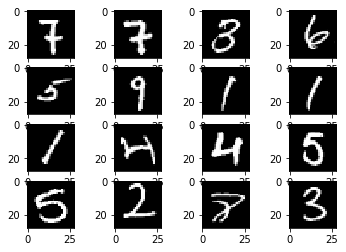

In [462]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    x = x.unsqueeze(0)
    I = bn(x).squeeze(0).squeeze(0)
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), сделать выводы


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \times \ m_{t-1} + (1 - \alpha)\times g - момент \\ 
v_t &= \beta \times v_{t-1} +  (1-\beta)\times g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\times \hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^2}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$

Полезные функции

```python
import torch
torch.zeros_like(x)  # сделать тензор нулей такойже как x
tensor.addcmul_, addcdiv_, mul_  # все функции операции с тензорами, которые заканчиваются на _ присваивают результат в self тензор 
```


In [477]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                # сами параметры для обновления лежат тут
                # p.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(grad)
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(grad)

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                # TODO
                exp_avg.mul_(beta1)
                exp_avg.add_((1. - beta1) * grad)
                exp_avg_sq.mul_(beta2)
                exp_avg_sq.add_((1. - beta2) * grad ** 2)
                step_size = lr * (1. - beta2 ** state['step']) ** 2 / (1. - beta1 ** state['step'])
                # обновляем веса в p.data, 
                # TODO
                p.data.addcdiv_(-1 * step_size, exp_avg, (exp_avg_sq + eps) ** (1. / 2))
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta \times m_{t-1} - (1- \beta) \times g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha \times m_{t-1} - \lambda \times g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [466]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания, если 0, получаем обычный SGD
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                state = self.state[p]
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    # todo
                    if len(state) == 0:
                        state['moment'] = torch.zeros_like(grad)
                        
                    moment = state['moment']
                    moment.mul_(beta)
                    moment.add_((beta - 1.) * grad)
                else:
                    moment = -grad
                # обновляем веса
                # to do
                # p.data
                p.data.add_(moment * lr)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [467]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


('original', array([0, 0, 0, ..., 9, 9, 9]))


In [468]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [469]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
            

        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            

        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [470]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [472]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net 
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(20, net, optimizer) # обучаем сеть

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.145578533431
Do epoch 1 with loss 0.0450947018631
Do epoch 2 with loss 0.0356545631382
Do epoch 3 with loss 0.0295967869273
Do epoch 4 with loss 0.0260795442874
Do epoch 5 with loss 0.024229712723
Do epoch 6 with loss 0.0201213193515
Do epoch 7 with loss 0.0180466864744
Do epoch 8 with loss 0.0170254555599
Do epoch 9 with loss 0.0146510325778
Do epoch 10 with loss 0.0141701184428
Do epoch 11 with loss 0.0132939471507
Do epoch 12 with loss 0.0117436864289
Do epoch 13 with loss 0.0108847209292
Do epoch 14 with loss 0.00978017259418
Do epoch 15 with loss 0.00959525948921
Do epoch 16 with loss 0.00736897621707
Do epoch 17 with loss 0.00814319129779
Do epoch 18 with loss 0.00757165958021
Do epoch 19 with loss 0.00744302191988


## SGD с моментом

In [494]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.118442628562
Do epoch 1 with loss 0.0453778927389
Do epoch 2 with loss 0.0346430479581
Do epoch 3 with loss 0.0294939919925
Do epoch 4 with loss 0.024593030815
Do epoch 5 with loss 0.0227942059151
Do epoch 6 with loss 0.0194502941954
Do epoch 7 with loss 0.0175771386617
Do epoch 8 with loss 0.0146969803219
Do epoch 9 with loss 0.0147265003433
Do epoch 10 with loss 0.0142598767421
Do epoch 11 with loss 0.0121386547338
Do epoch 12 with loss 0.0109970125131
Do epoch 13 with loss 0.0106196158694
Do epoch 14 with loss 0.0108704961424
Do epoch 15 with loss 0.00858559163401
Do epoch 16 with loss 0.00870425001666
Do epoch 17 with loss 0.00782504880815
Do epoch 18 with loss 0.00688826075743
Do epoch 19 with loss 0.00570372259393


## Adam

In [495]:
learning_rate = 1e-4
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 1.53402404872
Do epoch 1 with loss 0.24297016719
Do epoch 2 with loss 0.106000859091
Do epoch 3 with loss 0.0733154607987
Do epoch 4 with loss 0.0586756182674
Do epoch 5 with loss 0.0498631887298
Do epoch 6 with loss 0.0440262739223
Do epoch 7 with loss 0.0391105957087
Do epoch 8 with loss 0.0358774949139
Do epoch 9 with loss 0.0332527723918
Do epoch 10 with loss 0.0305980122391
Do epoch 11 with loss 0.0283228889666
Do epoch 12 with loss 0.0263114482382
Do epoch 13 with loss 0.0242977803245
Do epoch 14 with loss 0.0236205804631
Do epoch 15 with loss 0.0221192404001
Do epoch 16 with loss 0.0204919513926
Do epoch 17 with loss 0.0196786322446
Do epoch 18 with loss 0.018213308748
Do epoch 19 with loss 0.0177226524424


# Кривые обучения

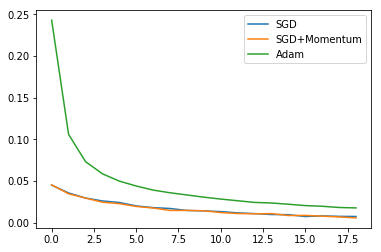

In [496]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam' )
ax.legend()
# lr1, lr2, lr3 = 1e-1, 1e-1, 1e-4
# beta = 0.9
# beta1, beta2 = 0.9, 0.999

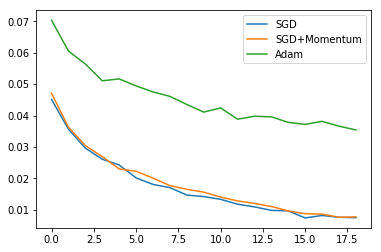

In [491]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam' )
ax.legend()
# lr1, lr2, lr3 = 1e-1, 1e-1, 1e-2
# beta = 0.5
# beta1, beta2 = 0.5, 0.5

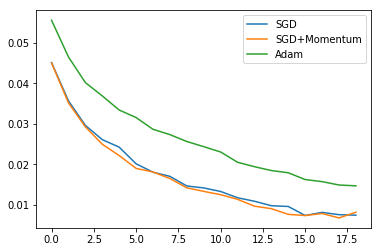

In [488]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam' )
ax.legend()
# lr1, lr2, lr3 = 1e-1, 1e-1, 1e-3
# beta = 0.5
# beta1, beta2 = 0.5, 0.5

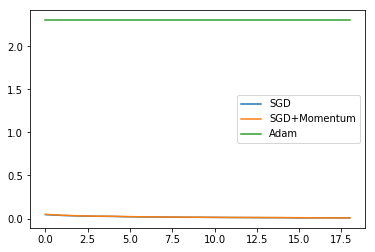

In [485]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam' )
ax.legend()
# lr = 1e-1
# beta = 0.9
# beta1, beta2 = 0.9, 0.9

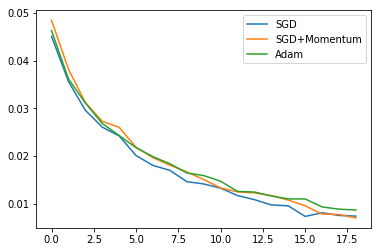

In [482]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam' )
ax.legend()
# lr1, lr2, lr3 = 1e-1, 1e-1, 1e-3
# SGD + momentum: beta = 0.9
# ADAM: beta1, beta2 = 0.9, 0.9

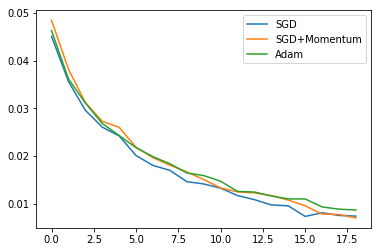

In [483]:
# графики без учета нулевой эпохи
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd[1:],label="SGD")
ax.plot(loss_curve_sgd_momentum[1:],label="SGD+Momentum")
ax.plot(loss_curve_adam[1:], label='Adam')
ax.legend()
# lr1, lr2, lr3 = 1e-1, 1e-1, 1e-3
# SGD + momentum: beta = 0.9
# ADAM: beta1, beta2 = 0.9, 0.999

### Выводы

_пишем выводы по сходимости и скорости обучения: Adam, SGD, SGD+momentum, с различными параметрами обучения lr и betas_

### При решении данной задачи лучше всего себя показал SGD-Momentum, на втором месте идет SGD и на третьем ADAM

#### Изменения learning rate и beta не изменили взаимное расположение методов оптимизации в это рейтинге, при этом все равно можно выделить следующие тенденции:
1. Изменение learning rate для ADAM ведет к ухудшению сходимости
2. Прим уменьшении параметра beta у ADAM заметно ухудшается сходимость, на SGD-Momentum это изменение никак не влияет

### Вывод: для решения этой задачи при заданном количстве эпох лучше всего подходит SGD-Momentum